In [3]:
import pandas as pd
pd.set_option('display.max_rows', 10000)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import sys
import glob
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.signal import savgol_filter
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import KFold
import torch.nn.functional as F
import torch.nn.init as init
import torch.nn.utils as torch_utils
import re
import torch
import gpytorch
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import torch
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C,RationalQuadratic,ExpSineSquared,DotProduct
from sklearn.multioutput import MultiOutputRegressor
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler,MaxAbsScaler
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.covariance import EllipticEnvelope
from sklearn.metrics import mean_squared_error


In [4]:
file = pd.ExcelFile('Indoor MPP_1.4 sun_ICN2_Feb. 2023_Tripple cat.-Variable Annealing temps.xlsx', engine='openpyxl')
sn = file.sheet_names
data_frame = pd.read_excel(file,sn[0],  engine='openpyxl')
temperature = data_frame.loc[(data_frame["Parameter"]     =="Annealing temperature")].to_numpy()  
temperature = temperature[2,2:]  
 
devices = data_frame.columns.to_numpy()
devices = np.reshape(devices, (devices.shape[0],1))
devices = devices[2:]
time_series_df = pd.read_excel(file,sn[-1],  engine='openpyxl')
time_series_df = time_series_df.drop(index =[0])
time = time_series_df.iloc[:,0]

 
time_series_1_4_sun = []
for i in range (temperature.shape[0]):
    time_series_1_4_sun.append(time_series_df.iloc[:,2+i*3])
time_series_1_4_sun = np.array(time_series_1_4_sun) 

 
 
outdoor_conditions = pd.read_csv('outdoor_conditions_unnormalized.txt', sep='\t')
irradiance = outdoor_conditions['irradiance']  
rh = outdoor_conditions['rh']  
outdoor_temperature = outdoor_conditions['outdoor_temperature']  
outdoor_condition_time = outdoor_conditions['time']  
irradiance = irradiance.fillna(irradiance.mean())
rh = rh.fillna(rh.mean())
outdoor_temperature = outdoor_temperature.fillna(outdoor_temperature.mean())
irradiance = irradiance.fillna(irradiance.mean())
rh = rh.fillna(rh.mean())

outdoor_panels = pd.read_csv('outdoor_data_imputed.txt', sep ='\t')
 
outdoor_panels_power = [] 
for i in range(temperature.shape[0]):
    outdoor_panels_power.append(outdoor_panels[str(i)])
outdoor_panels_power = np.array(outdoor_panels_power)  
 

 
time_series_1_4_sun_shape = time_series_1_4_sun.shape
time_series_1_4_sun = np.pad(time_series_1_4_sun, ((0,0),(0,outdoor_panels_power.shape[1] - time_series_1_4_sun.shape[1])),mode='edge' )    
time_series_1_4_sun = np.reshape(time_series_1_4_sun, ((time_series_1_4_sun.shape[0],time_series_1_4_sun.shape[1],1)))
outdoor_panels_power = np.reshape(outdoor_panels_power, ((outdoor_panels_power.shape[0],outdoor_panels_power.shape[1],1)))

In [5]:
time_series_1_4_sun_average = np.zeros((12, 4794, 1))
k = 0
for i in range(time_series_1_4_sun.shape[0]):
    if (i+1) % 2 == 0:
        time_series_1_4_sun_average[k] = np.mean(time_series_1_4_sun[i-1:i+1], axis=0)
        k += 1
 
outdoor_panels_power_average = np.zeros((12, 4794, 1))
b = 0
for i in range(outdoor_panels_power.shape[0]):
    if (i+1) % 2 == 0:
        outdoor_panels_power_average[b] = np.mean(outdoor_panels_power[i-1:i+1], axis=0)
        outdoor_panels_power_average[b][outdoor_panels_power_average[b] < 0] = 0  
        b += 1

 
outdoor_conditions_stacked = np.stack([outdoor_conditions ] * 12, axis=0)
 

In [6]:
def exponential_smoothing(series, alpha):
    smoothed_series = [series[0]]   
    for i in range(1, len(series)):
        smoothed_value = alpha * series[i] + (1 - alpha) * smoothed_series[-1]
        smoothed_series.append(smoothed_value)
    return np.array(smoothed_series)
 
 
for i in range (time_series_1_4_sun_average.shape[0]):
  time_series_1_4_sun_average[i] = exponential_smoothing(time_series_1_4_sun_average[i], 0.1)
  outdoor_panels_power_average[i] = exponential_smoothing(outdoor_panels_power_average[i], 0.7)

In [7]:
all_new_features = np.concatenate((time_series_1_4_sun_average ,outdoor_conditions_stacked), axis=2) 
print(outdoor_panels_power_average.shape)

(12, 4794, 6)
(12, 4794, 1)


In [8]:
num_samples =all_new_features.shape[0]
all_new_features_reshaped = all_new_features.reshape(num_samples, -1)
outdoor_panels_power_average_reshaped = outdoor_panels_power_average.reshape(num_samples, -1)
num_folds = 12

 
average_mse_scores1 = []
average_mse_scores2 = []
fold = 0
y_pred1=np.zeros(( 1, 4794))
y_pred2=np.zeros(( 1, 4794))
predictions1 = np.zeros((12, 1, 4794))
test1= np.zeros((12, 1, 4794))
predictions2 = np.zeros((12, 1, 4794))
test2 = np.zeros((12, 1, 4794))
 
 

for temp in range(6):
    test_index=[2*temp,2*temp+1]
    train_index = [i for i in range(num_samples) if i not in test_index]
    print(test_index)
    print(train_index )
 
    X_train, X_test = all_new_features_reshaped [train_index], all_new_features_reshaped [test_index]
    y_train, y_test = outdoor_panels_power_average_reshaped[train_index], outdoor_panels_power_average_reshaped[test_index]
    scaler = MaxAbsScaler()
    X_train= scaler.fit_transform(X_train)
    X_test= scaler.transform(X_test)
    print(X_test.shape)
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=10, max_depth=3, learning_rate=0.1,
                                 reg_alpha=0.1, reg_lambda=0.1)
    xgb_model.fit(X_train, y_train)
    y_pred1 =xgb_model.predict(X_test[0].reshape(1, -1))
    y_pred2 =xgb_model.predict(X_test[1].reshape(1, -1))
    predictions1[fold] = y_pred1
    predictions2[fold] = y_pred2
    test1[fold] = y_test[0]
    test2[fold] = y_test[1]
    error1 = mean_squared_error(y_test[0].reshape(1, -1), y_pred1)
    error2= mean_squared_error(y_test[1].reshape(1, -1), y_pred2)
    print("Fold {} - Mean Squared Error: {}".format(fold + 1, error1))
    print("Fold {} - Mean Squared Error: {}".format(fold + 1, error2))

    average_mse_scores1.append(error1)
    average_mse_scores2.append(error2)
    fold = fold + 1
    if fold == 6:
        break
average_mse1 = np.mean(average_mse_scores1)
average_mse2 = np.mean(average_mse_scores2)
print(f"Average Mean Squared Error: {average_mse1}")
print(f"Average Mean Squared Error: {average_mse2}")

[0, 1]
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
(2, 28764)


Fold 1 - Mean Squared Error: 0.7590474080731637
Fold 1 - Mean Squared Error: 0.2578131279107836
[2, 3]
[0, 1, 4, 5, 6, 7, 8, 9, 10, 11]
(2, 28764)
Fold 2 - Mean Squared Error: 2.4783638236747954
Fold 2 - Mean Squared Error: 3.545356377640718
[4, 5]
[0, 1, 2, 3, 6, 7, 8, 9, 10, 11]
(2, 28764)
Fold 3 - Mean Squared Error: 1.5629535350908494
Fold 3 - Mean Squared Error: 1.0717203985991337
[6, 7]
[0, 1, 2, 3, 4, 5, 8, 9, 10, 11]
(2, 28764)
Fold 4 - Mean Squared Error: 1.0703327056471554
Fold 4 - Mean Squared Error: 1.1724088275222895
[8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 10, 11]
(2, 28764)
Fold 5 - Mean Squared Error: 0.1588086227225488
Fold 5 - Mean Squared Error: 0.7332914691210799
[10, 11]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
(2, 28764)
Fold 6 - Mean Squared Error: 3.0252678238934148
Fold 6 - Mean Squared Error: 0.8283666777213834
Average Mean Squared Error: 1.509128986516988
Average Mean Squared Error: 1.2681594797525646


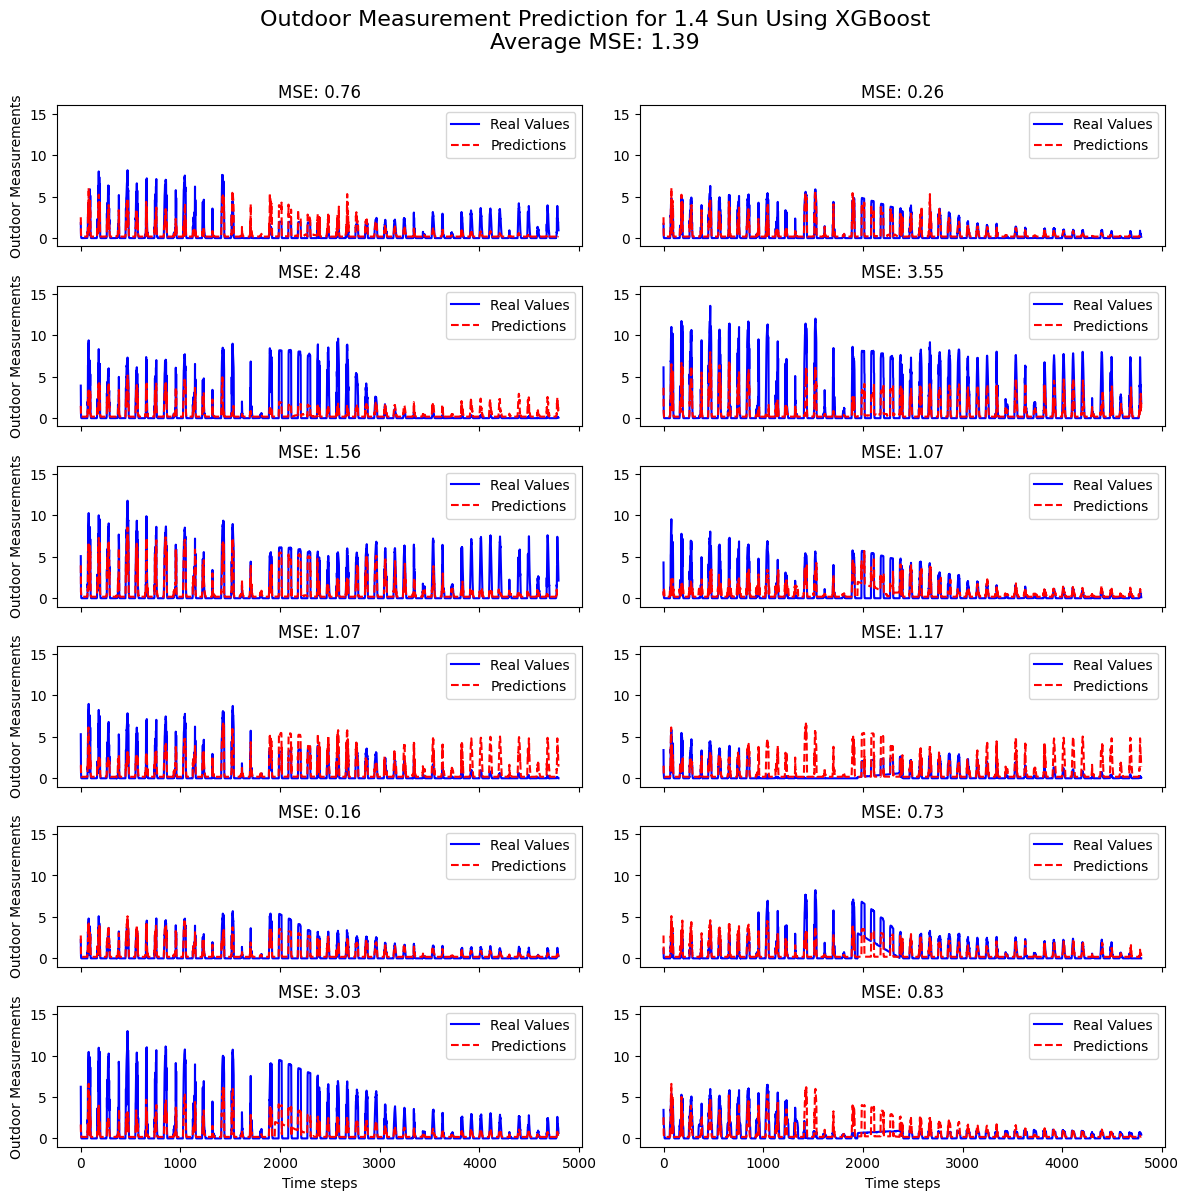

In [11]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(6, 2, figsize=(12, 12), sharex=True)


for fold in range(6):
  
    y_pred_fold1 = predictions1[fold].squeeze()  
    y_pred_fold2 = predictions2[fold].squeeze()
    y_test_fold1 = test1[fold].squeeze()
    y_test_fold2 = test2[fold].squeeze()

    axes[fold, 0].plot(y_test_fold1, label='Real Values', color='blue')
    axes[fold, 0].plot(y_pred_fold1, label='Predictions', color='red',linestyle='dashed')
    axes[fold, 0].set_ylabel('Outdoor Measurements')
     
    axes[fold, 0].set_title(f'MSE: {average_mse_scores1[fold]:.2f}')
    axes[fold, 0].legend()
    axes[fold, 0].set_ylim(-1, 16)
   
    axes[fold, 1].plot(y_test_fold2, label='Real Values', color='blue')
    axes[fold, 1].plot(y_pred_fold2, label='Predictions', color='red',linestyle='dashed')
     
    axes[fold, 1].set_title(f'MSE: {average_mse_scores2[fold]:.2f}') 
    axes[fold, 1].legend()
    axes[fold, 1].set_ylim(-1, 16)

plt.tight_layout()
average_mse_all = (average_mse1+average_mse2)/2
axes[-1, 0].set_xlabel('Time steps')
axes[-1, 1].set_xlabel('Time steps')
fig.suptitle(f'Outdoor Measurement Prediction for 1.4 Sun Using XGBoost\nAverage MSE: {average_mse_all:.2f}', fontsize=16)
fig.subplots_adjust(top=0.9)
plt.savefig('1.4 sun using XGBoost.pdf')
plt.show()